---
title: "Varying Coefficient GARCH"
author: "Sarem"
date: "2023-01-19"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Let's make GARCH have varying coefficients to handle non-linear conditional variance."
---

## Introduction

As you can probably tell by my other articles (for example [here](https://www.sarem-seitz.com/random-forests-and-boosting-for-arch-like-volatility-forecasts/), [here](https://www.sarem-seitz.com/multivariate-garch-with-python-and-tensorflow/) and [here](https://www.sarem-seitz.com/lets-make-garch-more-flexible-with-normalizing-flows/)), I am a big fan of GARCH models. Forecasting conditional variance is arguably the best we can get in predicting stock returns out of themselves.

Still, the GARCH family is no silver bullet that suddenly makes you a stock wizard. Countless variations imply that there is no single best approach to handle conditional variance.

Today, let us look at one interesting variant of GARCH - namely, **Varying Coefficient GARCH**. If you are in a hurry, you can find the **Jupyter notebook** corresponding to this article [here](https://github.com/SaremS/sample_notebooks/blob/master/Varying%20Coefficient%20GARCH.ipynb?ref=sarem-seitz.com).

## Drawbacks of traditional GARCH
First, we'll quickly go through some limitations of the standard GARCH model. Although we have discussed them before, it's always good to refresh important aspects of our models.

For simplicity, we will only go through `GARCH(1,1)`. The generalized version just uses an arbitrary number of lags for both squared observations and variance. Also, we assume a constant mean of zero.

With that in mind, `GARCH(1,1)` follows the following equations:
$$
\begin{gathered}
y_t \sim \mathcal{N}\left(0, \sigma_t^2\right) \\
\sigma_t^2=\omega+\alpha y_{t-1}^2+\beta \sigma_{t-1}^2 \\
\omega>0 \\
0<\alpha+\beta<1
\end{gathered}
$$
From these, we can derive two important issues:

### The linear assumption of GARCH
GARCH makes the relatively light assumption of variance being a linear combination of past data. On the one hand, this goes very well with Occam's razor. Simpler models are very often more robust.

One observation I often make when experimenting with more flexible GARCH models is overfitting. Consider a very bad probabilistic model for some data. If you allow variance to be very flexible, you just need to make that variance very large. Then, all of your training observations will still achieve a reasonably well likelihood or model fit.

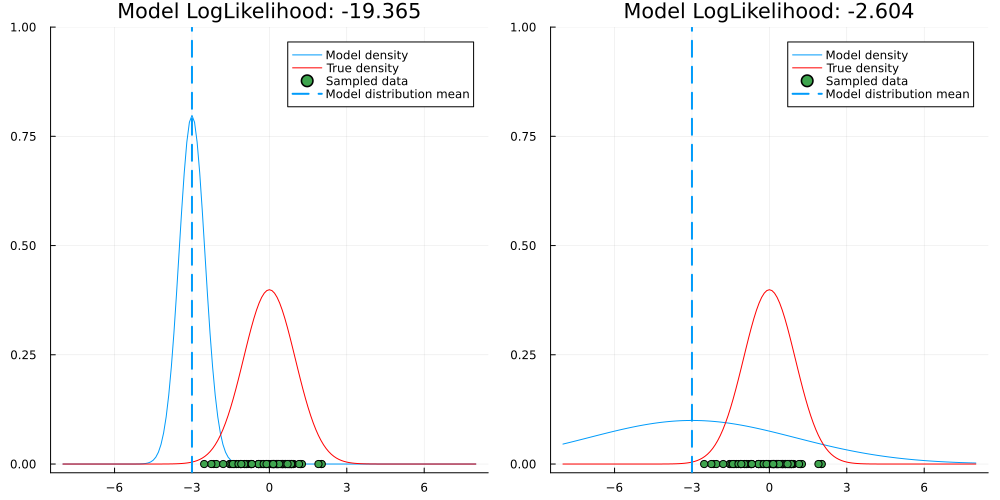

In [2]:
using Distributions, Random, Printf, Plots
Random.seed!(123)

data = randn(100)

dist1 = Normal(-3,0.5)
dist2 = Normal(-3,4)

ll1 = mean(logpdf.(dist1,data))
ll2 = mean(logpdf.(dist2,data))

line = collect(-8:0.1:8)

p1 = plot(line, pdf.(dist1,line), label="Model density", size=(1000,500), 
          ylim=(-0.02,1), title=@sprintf "Model LogLikelihood: %.3f" ll1)
plot!(p1, line,pdf.(Normal(),line),color=:red, label="True density")
scatter!(p1, data, zeros(100), label="Sampled data")
vline!(p1, [-3], color=1, linestyle=:dash, lw=2, label = "Model distribution mean")

p2 = plot(line, pdf.(dist2,line), label="Model density", size=(1000,500), 
          ylim=(-0.02,1), title=@sprintf "Model LogLikelihood: %.3f" ll2)
plot!(p2, line,pdf.(Normal(),line),color=:red, label="True density")
scatter!(p2, data, zeros(100), label="Sampled data")
vline!(p2, [-3], color=1, linestyle=:dash, lw=2, label = "Model distribution mean")

plot(p1,p2, size=(1000,500), fmt=:png)

Thus, the linearity assumption guarantees a sensible amount of model regularization. On the other hand, this might nevertheless be too restrictive when linearity is clearly not present in the data.

### The Gaussian assumption
Probably the most common assumption of all foundational statistical and econometrical models. In standard GARCH, we presume Gaussian observations as well. The only difference to your standard time-series models is that we are predicting variance, not the mean.

As mentioned countless times before, real-world data is almost never Gaussian. This is particularly the case for stock market returns, where GARCH is probably used the most. Hence, a fundamental assumption of our model stands in conflict with real-world observations.

In practice, the Gaussian distribution is often replaced by something more flexible. Examples include the location-scale [Student-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution?ref=sarem-seitz.com) distribution or the [Generalized Beta distribution](https://en.wikipedia.org/wiki/Generalized_beta_distribution?ref=sarem-seitz.com).

Today, we are considering the linearity issue of GARCH. For a possible treatment of the Gaussian issue, you can also take a look at [this article](https://www.sarem-seitz.com/lets-make-garch-more-flexible-with-normalizing-flows/) of mine.

## Motivation for Varying Coefficient GARCH
As already mentioned, the linearity assumption can be limiting. The obvious fix would be to just use some non-linear alternative and call it a day. However, there are two issues with that. Let us start with the bigger one first:

**It is difficult to prove stability of non-linear models**. Depending on our particular model, it can be tricky, if not impossible to ensure that it is well behaved. At worst, we could see the forecast going completely bonkers over time.

With a plain linear model and some fundamental theory, it is straightforward to ensure that this doesn't happen. Using an arbitrary model, though, this advantage can easily vanish.

The second issue is that **standard non-linear models are hard to interpret**. Consider again the standard GARCH setup: We can easily reason about the effect of each 'factor' in our model. Without further ado, we could also include additional factors like company sector, etc. in our model.

Obviously, this is not possible with an arbitrary, non-linear alternative anymore. Thus, considering both the above issues, a varying coefficient model becomes quite attractive.

### Varying coefficient models
The straightforward rationale of varying coefficient models is the following: If fixed parameters are restrictive, why not just make them dynamic?

And indeed, this is what varying coefficient models are all about. Our primary goal is to move from static coefficient to ones that are dynamic given different inputs.

In a linear regression model, this could look as follows:
$$
y=X \beta(X)
$$
The coefficients are simply a function of the inputs. Thus, each input can have a unique set of linear model parameters. This allows us to model non-linear functions in a - locally - linear fashion.

For standard regression models there exists a lot of previous research dating back into the nineties. Nowadays, we also see some modern approaches to varying coefficient models.

One example is [this fairly recent paper](https://proceedings.neurips.cc/paper/2018/file/3e9f0fc9b2f89e043bc6233994dfcf76-Paper.pdf?ref=sarem-seitz.com) which uses neural networks to model varying coefficients on a large scale. There, the approach is used for image classification. The findings are quite impressive - the model is able to highlight reasonable image sections that are most relevant for the model output.

Obviously, there also exists previous work on varying coefficient GARCH already, see for example

- [Here](https://www.degruyter.com/document/doi/10.1515/snde-2019-0091/html?lang=de&ref=sarem-seitz.com)
- [Here](https://www.scirp.org/pdf/ojs_2022062914594783.pdf?ref=sarem-seitz.com)
- [Here](https://link.springer.com/chapter/10.1007/978-3-540-71297-8_7?ref=sarem-seitz.com)

To keep things easy for now, we'll use a fairly simplistic variant. From there, you can try different variations yourself.

## Varying Coefficient GARCH
Let us re-state the standard `GARCH(1,1)` equations from before:
$$
\begin{gathered}
y_t \sim \mathcal{N}\left(0, \sigma_t^2\right) \\
\sigma_t^2=\omega+\alpha y_{t-1}^2+\beta \sigma_{t-1}^2 \\
\omega>0 \\
0<\alpha+\beta<1
\end{gathered}
$$
An alternative with varying coefficients then makes the coefficients a function of some variables of interest:
$$
\begin{gathered}
y_t \sim \mathcal{N}\left(0, \sigma_t^2\right) \\
\sigma_t^2=\omega+\alpha_t y_{t-1}^2+\beta_t \sigma_{t-1}^2 \\
\alpha_t=\phi\left(y_{t-1}, \sigma_{t-1}\right) \\
\beta_t=\psi\left(y_{t-1}, \sigma_{t-1}\right)
\end{gathered}
$$
Let us, again for simplicity, use a feedforward neural network to model the varying coefficients:

![Structural diagram of a varying coefficient GARCH model. The coefficients vary as a Neural Network function of past realizations and past standard deviation.](/varying-coefficient-garch/varcoeffgarch_structure.png){fig-alt="Structural diagram of a varying coefficient GARCH model."}

Now, we can take advantage of linearity in the varying coefficients and ensure stationarity via
$$
0<\alpha_t+\beta_t<1
$$
for all $t$

For static coefficient GARCH, it is relatively easy to ensure this stationarity condition. Just use one of the popular optimization packages and enter the respective linear constraint.

In the varying coefficient case this might, at first sight, not be as obvious. Libraries for neural networks don't allow any constraints on the network output out-of-box. Thus, we need to build a solution to this problem ourselves.

For GARCH(1,1), this is actually very simple. We only need to find a transformation of our network output, that ensures stationarity. In fact, we can simply do the following:
$$
\begin{aligned}
&\begin{gathered}
\alpha_t=\sigma\left(\tilde{\alpha}_t\right) \\
\beta_t=\left(1-\sigma\left(\tilde{\alpha}_t\right)\right) \cdot \sigma\left(\tilde{\beta}_t\right)
\end{gathered}\\
&\sigma(x)=\frac{1}{1+e^{-x}}
\end{aligned}
$$
By playing around with the sigmoid function, we can quickly find a suitable transformation. For arbitrary GARCH order, this can be more of a hassle, so we won't consider this case here.

### Some rationale behind the model
You might wonder why we don't make the parameters dependent on **squared** past realizations and past variance. For the latter, it shouldn't make that much of a difference if we used variance instead of standard deviation.

For past observations, though, there is a clear advantage: Negative and positive realizations of the time-series can affect future variance differently. In the stock market example, large negative returns are likely to cause greater variance in subsequent periods. This is, for example, the philosophy behind the [TGARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com#:~:text=.-,TGARCH,-model%5Bedit) model.

As for the neural network, we could also use other popular function approximators. This includes Regression Splines or higher order polynomials. Given their still undefeated popularity, I decided that neural networks would be the most interesting choice.

## A quick demonstration of varying coefficient GARCH
In other GARCH articles, I have primarily used Python for the implementation. Today, let us use Julia for fun and education. Personally, I find the language much more efficient for some quick experiments. On the other hand, deployment is less of a pleasure if you need to manage the JIT overhead.

We begin with the usual data loading process. Here, I used 5 years of DAX data from [yahoo finance](https://finance.yahoo.com/?ref=sarem-seitz.com) and calculated the log-returns of the adjusted close price. The final 100 observations are kept in a holdout set:

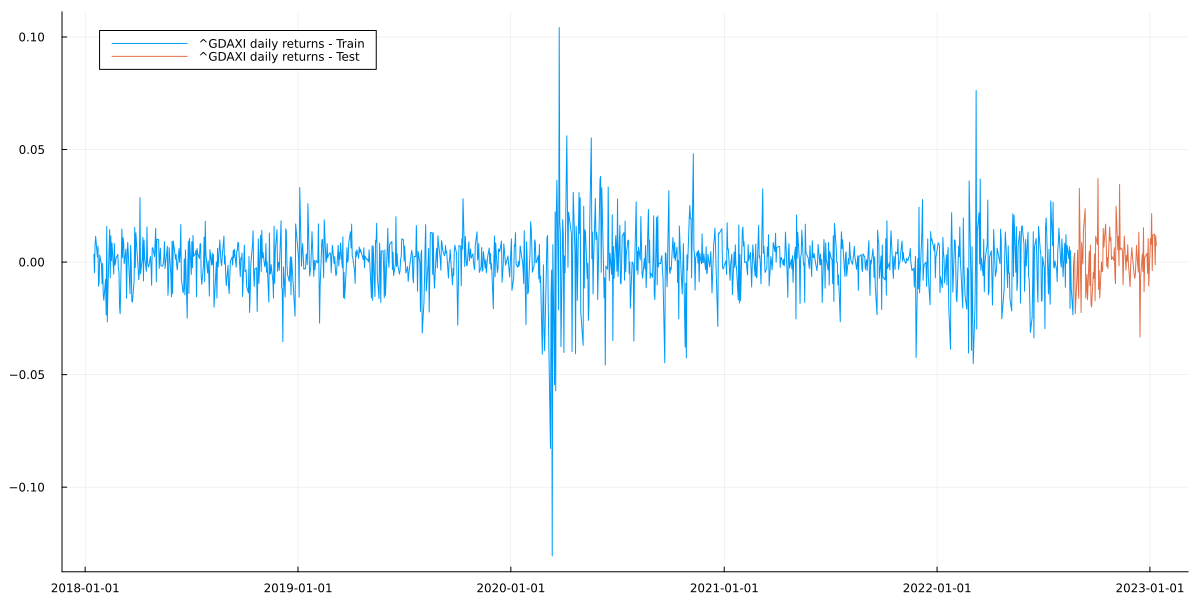

In [4]:
using Plots, CSV, DataFrames

#https://de.finance.yahoo.com/quote/%5EGDAXI/history?period1=1515801600&period2=1673568000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = CSV.File("../data/GDAXI.csv") |> DataFrame

a_close_raw = df[!,["Adj Close", "Date"]]
a_close_nonull = a_close_raw[findall(a_close_raw[!,"Adj Close"].!= "null"),:]
a_close = parse.(Float32, a_close_nonull[!,"Adj Close"])

returns = diff(log.(a_close))

train = returns[1:end-99]
train_idx = a_close_nonull[!,"Date"][2:end-99]

test = returns[end-99:end]
test_idx = a_close_nonull[!,"Date"][end-99:end]

plot(train_idx,train, label="^GDAXI daily returns - Train", size = (1200,600), fmt=:png)
plot!(test_idx, test, label="^GDAXI daily returns - Test")

Next, we create our varying coefficient GARCH. As Julia is more or less a functional language, there aren't any classes, unlike Python.

Also, we do not store the latent state of our model (= the conditional variance) over time. This is due to the fact that [`Zygote`](https://fluxml.ai/Zygote.jl/stable/?ref=sarem-seitz.com), one of Julia's AutoDiff libraries, doesn't allow mutating arrays. Rather, we recursively call the respective function and pass the current state to the next function call.

(Technically, it is possible to store intermediate states in a [`Zygote.Buffer`](https://fluxml.ai/Zygote.jl/stable/?ref=sarem-seitz.com). Let us here use the functional variant anyway for educational purposes.)

In [5]:
using Flux, Distributions


struct VarCoeffGARCH
    constant::Vector{Float32}
    net::Chain
    
    x0::Vector{Float32}
end
Flux.@functor VarCoeffGARCH

VarCoeffGARCH(net::Chain) = VarCoeffGARCH([-9], net, [0.0])


function garch_mean_ll(m::VarCoeffGARCH, y::Vector{Float32})::Float32
    sigmas, _ = garch_forward(m,y)
    conditional_dists = Normal.(0, sigmas)
    
    return mean(logpdf.(conditional_dists, y))
end


#Use functional implementation to calculate conditional stddev.
#Then, we don't need to store stddev_t to calculate stddev_t+1
#and thus avoid mutation, which doesn't work with Zygote
#(could use Zygote.Buffer, but it's often discouraged)
function garch_forward(m::VarCoeffGARCH, y::Vector{Float32})
    
    sigma_1, params_1 = m(m.x0[1], sqrt(softplus(m.constant[1])))
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_1, y, 1)
    
    sigmas_result = vcat(sigma_1, sigma_rec)
    params_result = hcat(params_1, params_rec)
    
    return sigmas_result, params_result
    
end

function garch_forward_recurse(m::VarCoeffGARCH, sigma_tm1::Float32, y::Vector{Float32}, t::Int64)
    
    sigma_t, params_t = m(y[t], sigma_tm1)
    
    if t==length(y)-1
        return sigma_t, params_t
    end
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_t, y, t+1)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    params_result = hcat(params_t, params_rec)
    
    return sigmas_result, params_result
end


function (m::VarCoeffGARCH)(y::Float32, sigma::Float32)
    
    input_vec = vcat(y, sigma)
    
    params = m.net(input_vec)
    params_stable = get_garch_stable_params(params) #to ensure stationarity of the resulting GARCH process
        
    return sqrt(softplus(m.constant[1]) + sum(input_vec.^2 .* params_stable)), params_stable
end

#transform both parameters to be >0 each and their sum to be <1
get_garch_stable_params(x::Vector{Float32}) = vcat(σ(x[1]), (1-σ(x[1]))*σ(x[2]))

get_garch_stable_params (generic function with 1 method)

Next, we create and train our varying coefficient GARCH model. Notice that I used a rather tiny architecture for the respective neural network. This hopefully counters the risk of overfitting to some extent.

If we were more engaged, we could experiment with different architectures. Here, however, this is left as an exercise to the reader.

In [6]:
using Random, Zygote

Random.seed!(123)

model = VarCoeffGARCH(Chain(Dense(2,2,softplus), Dense(2,2,softplus), Dense(2,2)))
params = Flux.params(model)

opt = ADAM(0.01)

for i in 1:500
    grads = Zygote.gradient(()->-garch_mean_ll(model, train), params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%50==0
        println(garch_mean_ll(model,train))
    end
end

2.973238
3.0015454
3.0188503
3.0298147
3.038704
3.0551393
3.0628562
3.0676363
3.0707815
3.0733144


Notice that we get the gradients via AutoDiff from `Zygote`. Another popular approach for GARCH models is to use black-box gradients via finite differences. Given that our neural network could easily have many more parameters, this would quickly become infeasible.

After model fitting, we can plot the in-sample predictions to check if everything went well:

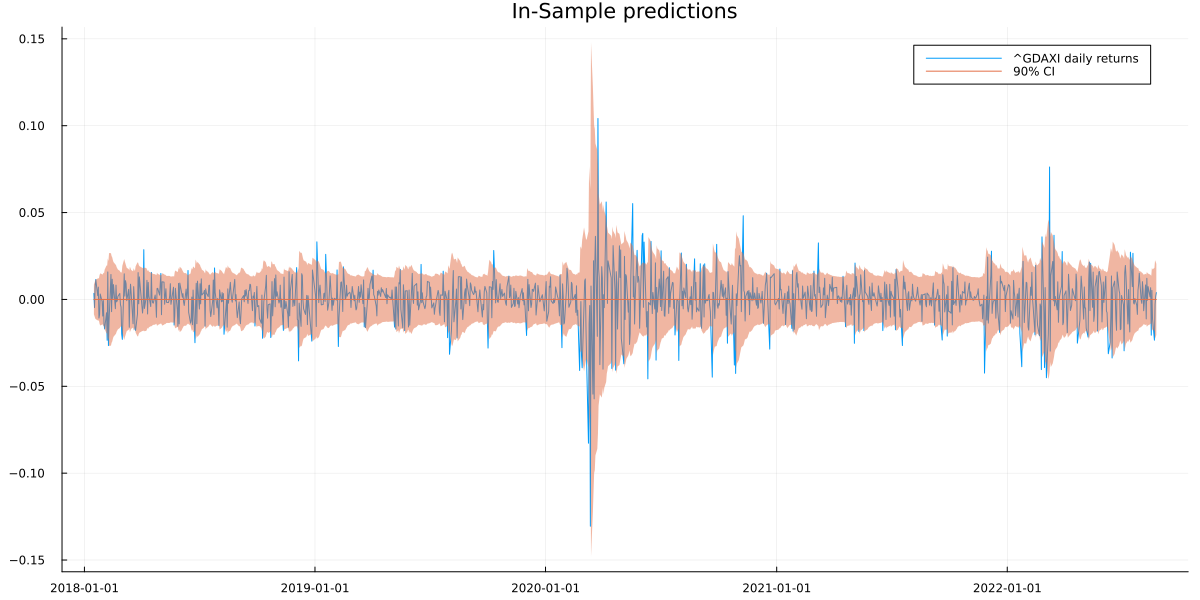

In [7]:
sigmas, params = garch_forward(model,train)

lower = quantile.(Normal.(0,sigmas),0.05)
upper = quantile.(Normal.(0,sigmas),0.95)

plot(train_idx, train, label="^GDAXI daily returns", size = (1200,600), title="In-Sample predictions", fmt=:png)
plot!(train_idx, zeros(length(lower)), ribbon=(upper,-lower),label = "90% CI")

This looks like a reasonable GARCH prediction for in-sample data. To see if it also works out-of-sample, we generate a forecast via MC-sampling. This is necessary as we cannot integrate out the probabilistic forecast at $t$ for $t+1$ analytically.

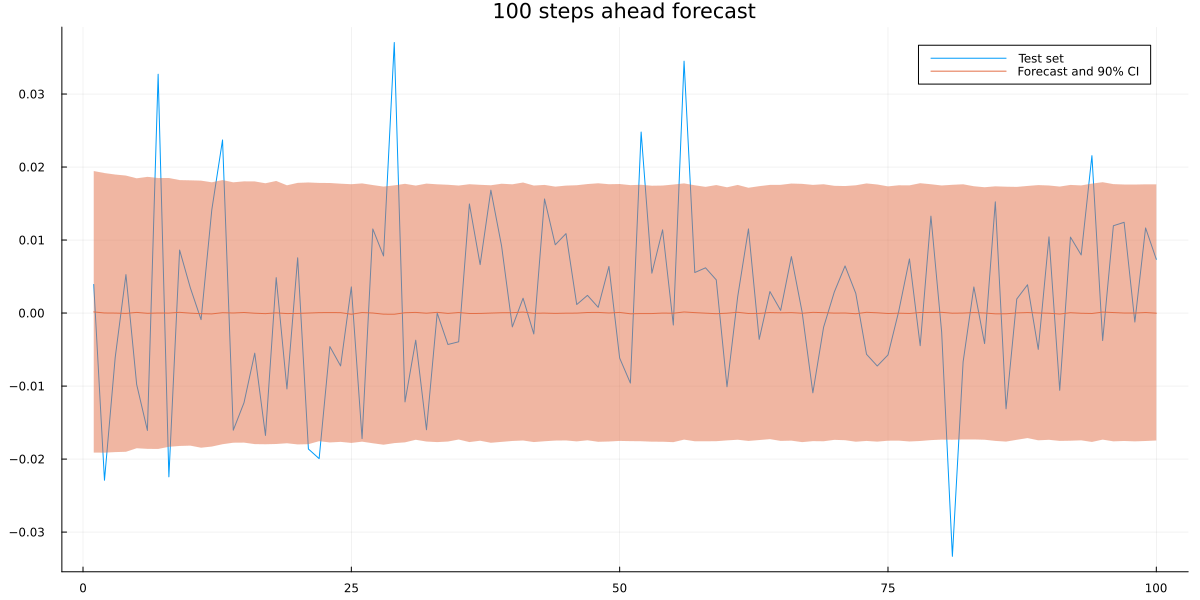

In [8]:
function garch_forward_sample(m::VarCoeffGARCH, sigma_tm1::Float32, y_tm1::Float32, t::Int64, T::Int64=100)
    
    sigma_t, params_t = m(y_tm1, sigma_tm1)
    sample_t = randn(Float32)*sigma_t
    
    if t==T
        return sigma_t, sample_t, params_t
    end
    
    sigma_rec, sample_rec, params_rec = garch_forward_sample(m, sigma_t, sample_t, t+1, T)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    sample_result = vcat(sample_t, sample_rec)
    params_result = vcat(params_t, params_rec)
    
    return sigmas_result, sample_result, params_result
    
end

Random.seed!(123)

mc_simulation = [garch_forward_sample(model, sigmas[end], train[end], 1) for _ in 1:25000]

sigma_sample = hcat(map(x->x[1], mc_simulation)...)
y_forecast_sample = hcat(map(x->x[2], mc_simulation)...)
params1_sample = hcat(map(x->x[3], mc_simulation)...)
params2_sample = hcat(map(x->x[3], mc_simulation)...)

y_forecast_mean = mean(y_forecast_sample,dims=2)[:]
y_forecast_lower = mapslices(x->quantile(x,0.05), y_forecast_sample, dims=2)[:]
y_forecast_upper = mapslices(x->quantile(x,0.95), y_forecast_sample, dims=2)[:]

plot(test[1:100], size = (1200,600), title = "100 steps ahead forecast", label="Test set", fmt=:png)
plot!(y_forecast_mean, ribbon = (y_forecast_upper.-y_forecast_mean, y_forecast_mean.-y_forecast_lower), label="Forecast and 90% CI")

Again, a reasonably looking plot. Since we also want to check if we built anything useful, let us also compare to a standard GARCH(1,1) forecast. We need to integrate out numerically once more:

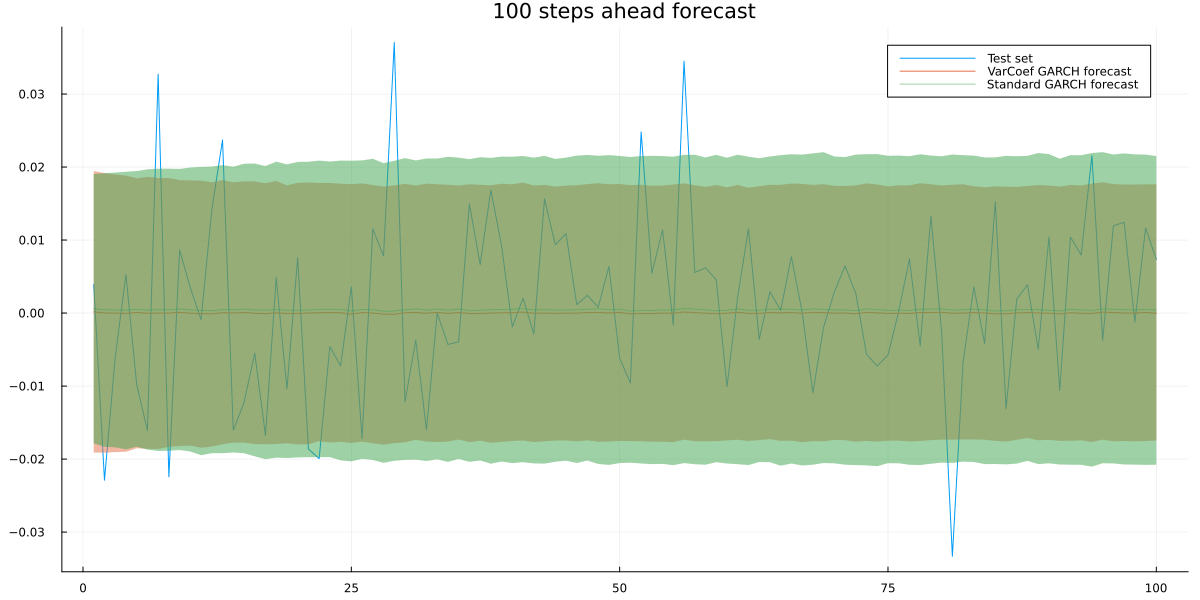

In [9]:
using ARCHModels

garch_model = fit(GARCH{1,1}, train)
garch_model_dummy = fit(GARCH{1,1}, train[1:end-1]) #to get latent variance of final training observation


Random.seed!(123)

var_T = predict(garch_model_dummy, :variance, 1)
y_T = train[end]

garch_coefs = garch_model.spec.coefs
mean_coef = garch_model.meanspec.coefs[1]

garch_sigma_sample = zeros(100,25000)
garch_forecast_sample = zeros(100,25000)

for i in 1:25000
    sigma_1 = sqrt(garch_coefs[1] + garch_coefs[2]*var_T + garch_coefs[3]*(y_T-mean_coef)^2)
    garch_sigma_sample[1,i] = sigma_1
    
    forecast_sample = randn()*sigma_1+mean_coef
    garch_forecast_sample[1,i] = forecast_sample
    
    for t in 2:100
        var_tm1 = garch_sigma_sample[t-1,i]^2
        eps_tm1 = (garch_forecast_sample[t-1,i]-mean_coef)^2
        
        sigma_t = sqrt(garch_coefs[1] + garch_coefs[2]*var_tm1 + garch_coefs[3]*eps_tm1)
        garch_sigma_sample[t,i] = sigma_t
        
        forecast_sample = randn()*sigma_t+mean_coef
        garch_forecast_sample[t,i] = forecast_sample
    end
end
    
garch_forecast_mean = mean(garch_forecast_sample,dims=2)[:]
garch_forecast_lower = mapslices(x->quantile(x,0.05), garch_forecast_sample, dims=2)[:]
garch_forecast_upper = mapslices(x->quantile(x,0.95), garch_forecast_sample, dims=2)[:]

plot(test[1:100], size = (1200,600), title = "100 steps ahead forecast", label="Test set", fmt=:png)
plot!(y_forecast_mean, ribbon = (y_forecast_upper.-y_forecast_mean, y_forecast_mean.-y_forecast_lower), label="VarCoef GARCH forecast")
plot!(garch_forecast_mean, 
      ribbon = (garch_forecast_upper.-garch_forecast_mean, garch_forecast_mean.-garch_forecast_lower),
      label="Standard GARCH forecast", alpha=0.5)

The standard GARCH model produces a larger forecast interval. To make both models comparable quantitatively, we use the average out-of-sample log-likelihoods:

In [10]:
using KernelDensity
var_coef_ll = mean([log(pdf(kde(y_forecast_sample[t,:]),test[t])) for t in 1:100])
standard_ll = mean([log(pdf(kde(garch_forecast_sample[t,:]),test[t])) for t in 1:100])

println(var_coef_ll)
println(standard_ll)

3.006017233022985
3.0003596946242705


Our model has a slightly better out-of-sample log-likelihood. Obviously, we could likely improve this with different architectures and/or a higher GARCH model order. Just try not to overfit!

Finally, we can take a look at the behaviour of the varying coefficients. One interesting view is past in-sample observations against each coefficient. For comparison, I also added the fixed coefficient from standard GARCH:

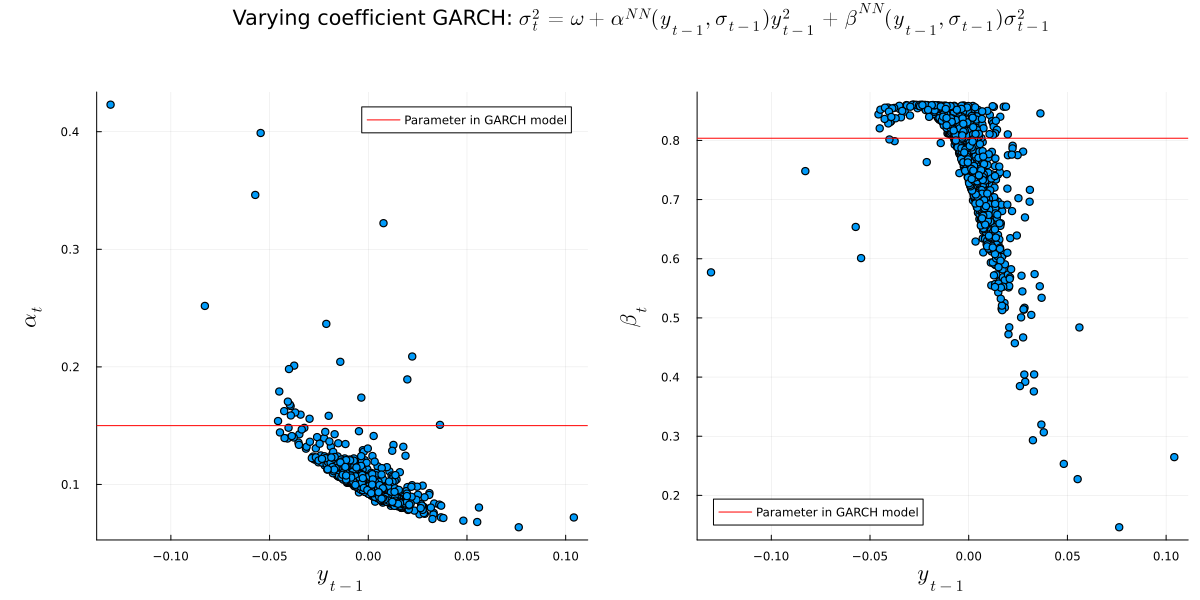

In [11]:
using LaTeXStrings

title = plot(title = "Varying coefficient GARCH: "*L"\sigma^2_t=\omega + \alpha^{NN}(y_{t-1},\sigma_{t-1})y^2_{t-1}+\beta^{NN}(y_{t-1},\sigma_{t-1})σ^2_{t-1}", grid = false, showaxis = false)


p1 = scatter(train[1:end-1], params[1,2:end], label=:none, guidefontsize=15)
xlabel!(p1,L"y_{t-1}")
ylabel!(p1,L"\alpha_t")
hline!([garch_coefs[3]], color=:red, label="Parameter in GARCH model")


p2 = scatter(train[1:end-1], params[2,2:end], label=:none, guidefontsize=15)
xlabel!(p2,L"y_{t-1}")
ylabel!(p2,L"\beta_t")
hline!([garch_coefs[2]], color=:red, label="Parameter in GARCH model")


plot(title, p1, p2, layout = @layout([A{0.01h}; [B C]]), size = (1200,600), left_margin=10*Plots.mm, bottom_margin=5*Plots.mm,fmt=:png)

Interestingly, both varying coefficients are in the same ballpark as standard GARCH. This adds some confidence that we are on the right track.

Nevertheless, as mentioned above, there is possibly still a lot of room for improvement.

## Conclusion
Now, where do we go from here? To put it bluntly, we have yet another GARCH variation that promises to fix one limitation of standard GARCH. With a little sophistication, we get a model that is flexible and fairly transparent at the same time.

Now we could, for example, easily introduce external factors to our model. The current state of the general economy or the company's sector are likely to influence return volatility.

With our varying coefficient GARCH, we can account for such effects. At the same time, it is possible to validate the predicted effect of each feature.

The biggest advantage in my opinion is, however, that we don't have to worry about stationarity. If we restrict our model to always yield valid GARCH coefficients, there is no risk of exploding forecasts.

This makes this model quite powerful, yet fairly simple to handle. If you have any questions about it, please let me know.

## References
**[1]** Bollerslev, Tim. Modelling the coherence in short-run nominal exchange rates: a multivariate generalized ARCH model. The review of economics and statistics, 1990, p. 498-505.

**[2]** Donfack, Morvan Nongni; Dufays, Arnaud. Modeling time-varying parameters using artificial neural networks: a GARCH illustration. Studies in Nonlinear Dynamics & Econometrics, 2021, p. 311-343.

**[3]** Hastie, Trevor; Tishbirani, Robert. Varying coefficient models. Journal of the Royal Statistical Society: Series B (Methodological), 1993, p. 757-779.